## Control Variates for Variance Reduction

We use the expected value of the terminal asset price S_T as a control variate because its expected value under the risk-neutral measure is known and analytically tractable.

This technique adjusts our Monte Carlo estimate by reducing variance using a correlated control variable with known expectation.

Formula:

Adjusted Estimate = X + c (Y_true - Y)

Where:
	•	X: Monte Carlo price of the exotic option
	•	Y: Simulated terminal stock price(the control variate)
	•   Y_true: Expected true mean of stock
	•	c: cov(X, Y) / var(Y)

This approach leverages the strong correlation between the exotic option price and the underlying asset value at maturity S_T, thereby improving the efficiency and accuracy of the Monte Carlo estimator.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [22]:
# Black Scholes Formula for a European Call Option

def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0/K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))

    bs_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    return bs_price

In [23]:
# Monte Carlo Simulation for Control Variate Technique

def control_variates_mc(S0, K, r, T, sigma, N):
    Z = np.random.randn(N)

    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    # X: Payoff of exotic option (same as European call for now)
    payoff_target = np.exp(-r*T) * (np.maximum(S_T - K, 0))

    # Y: Control Variate (Simulated Stock Price at Maturity)
    payoff_control =  S_T

    # Y_true: Expected Known Price (True Mean of Control Variate)
    expected_ST = S0 * np.exp(r * T)

    # Calculate c = - Cov(X, Y) / Var(Y)
    cov_XY = np.cov(payoff_target, payoff_control)[0, 1]
    var_Y = np.var(payoff_control)
    c = cov_XY / var_Y

    # Adjusted Estimate
    adjusted_estimate = np.mean(payoff_target + c * (expected_ST - payoff_control))

    return adjusted_estimate, np.mean(payoff_target)

In [30]:
# Comparing Estimates
# parameters

S0 = 100
K = 100
r = 0.05
T = 1
sigma = 0.2
N = 100000

bs_price = black_scholes_call(S0, K, T, r, sigma)
adjusted, unadjusted = control_variates_mc(S0, K, r, T, sigma, N)

print(f"Black-Scholes price: {bs_price:.4f}")
print(f"Monte Carlo Unadjusted: {unadjusted:.4f}")
print(f"Control Variates Adjusted: {adjusted:.4f}")


Black-Scholes price: 10.4506
Monte Carlo Unadjusted: 10.4155
Control Variates Adjusted: 10.4396


Std Dev - Plain MC        : 0.1419
Std Dev - Control Variates: 0.0559


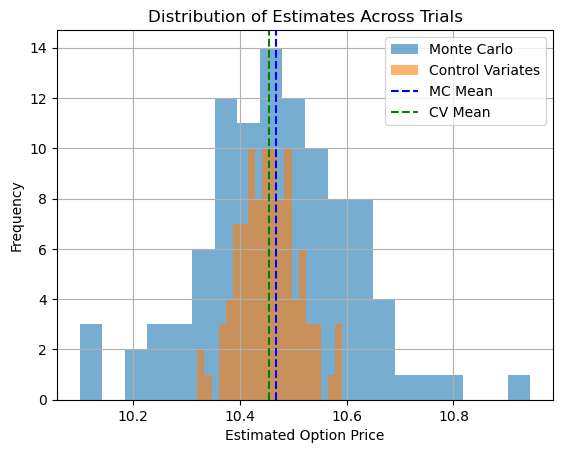

In [18]:
# Comparing Varience (Standard Deviation) of prices.

def compare_variance_cv(S0, K, r, T, sigma, N=10000, trials=100):
    mc_prices = []
    cv_prices = []

    for i in range(trials):

        # Plain Monte Carlo
        Z = np.random.randn(N)
        S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
        payoff = np.exp(-r * T) * np.maximum(S_T - K, 0)
        mc_prices.append(np.mean(payoff))

        # Control variates: use S_T as control
        payoff_control = S_T
        expected_ST = S0 * np.exp(r * T)
        c = np.cov(payoff, payoff_control)[0, 1] / np.var(payoff_control)
        cv_price = np.mean(payoff + c * (expected_ST - payoff_control))
        cv_prices.append(cv_price)

    std_mc = np.std(mc_prices)
    std_cv = np.std(cv_prices)

    print(f"Std Dev - Plain MC        : {std_mc:.4f}")
    print(f"Std Dev - Control Variates: {std_cv:.4f}")

    #plotting
    plt.hist(mc_prices, bins=20, alpha=0.6, label='Monte Carlo')
    plt.hist(cv_prices, bins=20, alpha=0.6, label='Control Variates')
    plt.axvline(np.mean(mc_prices), color='blue', linestyle='--', label='MC Mean')
    plt.axvline(np.mean(cv_prices), color='green', linestyle='--', label='CV Mean')
    plt.title("Distribution of Estimates Across Trials")
    plt.xlabel("Estimated Option Price")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the comparison
compare_variance_cv(S0=100, K=100, r=0.05, T=1, sigma=0.2)